# **Kalman filters for Non-Gaussian Noises**
Week 11, group 3

# **Standard Kalman Filter**
- Assumes linear system and Gaussian noise.
- Optimal estimator under those conditions.
- Fails when noise is heavy-tailed or has outliers.


**State-space model:**

$$
x_{k+1} = A x_k + B u_k + w_k, \quad w_k \sim \mathcal{N}(0, Q)
$$

$$
y_k = H x_k + v_k, \quad v_k \sim \mathcal{N}(0, R)
$$

**Prediction step:**

$$
\hat{x}_{k|k-1} = A \hat{x}_{k-1|k-1} + B u_k
$$

$$
P_{k|k-1} = A P_{k-1|k-1} A^T + Q
$$

**Update step:**

$$
K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1}
$$

$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (y_k - H \hat{x}_{k|k-1})
$$

$$
P_{k|k} = (I - K_k H) P_{k|k-1}
$$


# **Limitations of the standard Kalman filter**
* Suboptimal performance: The standard Kalman filter is **not optimal for non-Gaussian noise** because it relies on second-order statistics (mean and covariance), which do not fully capture the characteristics of non-Gaussian distributions.
* Breakdown: In the presence of non-Gaussian noise, such as impulsive or Laplace noise, the standard Kalman filter can become biased or even break down.
* Assumption failure: The standard filter may fail when its core assumptions about noise distributions are not met in real-world applications like image processing, medical data, and speech.

# **Solutions / Extensions**
- **Extended Kalman Filter (EKF)**: handles nonlinearities, but still assumes Gaussian noise.
- **Unscented Kalman Filter (UKF)**: better for nonlinear systems, but same Gaussian assumption.
- **Robust Kalman Filters**: modify update step to reduce sensitivity to outliers.
- **Particle Filters**: Monte Carlo methods that approximate arbitrary distributions.

method with approximating Gaussianity

**Extended Kalman Filter (EKF)**
- Handles nonlinear systems by linearizing around the current estimate.
- Still assumes Gaussian noise.
- Works well for mildly nonlinear problems, but sensitive to strong non-Gaussian noise.


**Unscented Kalman Filter (UKF)**
- Uses deterministic sampling (sigma points) to capture mean and covariance more accurately.
- Better than EKF for highly nonlinear systems.

# **Robust Kalman Filter**
- Modifies the update step using robust statistics (Huber loss, L1 norm).
- Downweights outliers in measurements.
- Sacrifices some optimality under Gaussian noise but gains stability under non-Gaussian noise.

Steps:
1. Predict the next state like a normal Kalman filter.
2. When a new measurement comes in, check if it’s reasonable.
3. If it looks too far off (outlier), reduce its influence instead of trusting it fully.
4. Update the estimate carefully, giving less weight to suspicious data.
5. Keep tracking smoothly even with bad readings.

Residual:

$$
r_k = y_k - H \hat{x}_{k|k-1}
$$

Huber function:

$$
\phi(r_k) =
\begin{cases}
r_k & |r_k| \leq \delta \\
\delta \cdot \text{sign}(r_k) & |r_k| > \delta
\end{cases}
$$

Update:

$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k \, \phi(r_k)
$$



*   For small residuals, it behaves like the standard KF (since noise looks Gaussian)
*   For large residuals, it limits the influence of that measurement (outlier rejection)



| Type                   | Robust Function            | Idea                                   |
| ---------------------- | -------------------------- | -------------------------------------- |
| **Huber-based KF**     | Piecewise quadratic/linear | Handles mild outliers                  |
| **M-estimator KF**     | General ψ-function         | Minimizes robust cost function         |
| **Cauchy or Tukey KF** | Bounded influence          | Completely suppresses extreme outliers |
| **Adaptive RKF**       | Dynamically tunes δ or R   | Adjusts robustness online              |


https://ieeexplore.ieee.org/abstract/document/769393

# **Particle Filter**
used for highly nonlinear or non-Gaussian systems.
- Monte Carlo method: represents distributions with random samples (particles).
- Can handle any noise distribution (non-Gaussian, multimodal).
- Flexible but computationally expensive compared to Kalman filters

Steps:
1. Randomly generate a bunch of particles
2. Predict next state of the particles: move particles based on how you predict the real system is behaving
3. Update the weights: Give higher weight to the good ones; lower to the bad ones.
5. Resample: keep more of the good particles and drop the weak ones.
6. The average of all particles gives the new best estimate.

Particles:

$$
\{x_k^{(i)}, w_k^{(i)}\}_{i=1}^N
$$

Prediction:

$$
x_k^{(i)} \sim p(x_k | x_{k-1}^{(i)}, u_k)
$$

Weight update:

$$
w_k^{(i)} \propto w_{k-1}^{(i)} \, p(y_k | x_k^{(i)})
$$

Resample after normalization.

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/04b2bea802321086effbd99402fc13c893d11110/12-Particle-Filters.ipynb

# Example 1: Robust Kalman Filter

Better estimate when the measurements are polluted by outliers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class HuberScore:
    """Robust Huber score function."""
    def __init__(self, delta=1.5):
        self._delta = delta

    def evaluate(self, z):
        if abs(z) >= self._delta:
            return self._delta * abs(z) - pow(self._delta, 2) / 2.0
        else:
            return pow(z, 2) / 2.0

    def derivative(self, z):
        if abs(z) >= self._delta:
            return self._delta * np.sign(z)
        else:
            return z

class VariablesHistory:
    """Utility to track variable history."""
    def __init__(self):
        self._variables_history = dict()

    def __getitem__(self, item):
        return self._variables_history[item]

    def update(self, variable_name, value):
        if variable_name not in self._variables_history:
            self._variables_history[variable_name] = []
        self._variables_history[variable_name].append(value.copy())

class RobustKalman:
    """Robust Kalman filter."""
    def __init__(self, F, B, H, x0, P0, Q0, R0, use_robust_estimation=False,
                 use_adaptive_statistics=False, robust_score=HuberScore(delta=1.5)):
        self.F = F.copy()
        self.B = B.copy() if B is not None else None
        self.H = H.copy()
        self.x = x0.copy()
        self.P = P0.copy()
        self.Q = Q0.copy()
        self.R = R0.copy()
        self.use_robust_estimation = use_robust_estimation
        self.use_adaptive_statistics = use_adaptive_statistics
        self.history_inovation = []
        self.r_mean_est = 0.0
        self.r_var_est = 0.0
        self.robust_score = robust_score

    def time_update(self, inputs=None):
        if inputs is None:
            self.x = self.F @ self.x
        else:
            self.x = self.F @ self.x + self.B @ inputs
        self.P = self.F @ self.P @ self.F.T + self.Q

    def measurement_update(self, measurements):
        self.inovation = measurements - self.H @ self.x
        Pinov = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(Pinov)

        if self.use_robust_estimation:
            epsilon_covariance = np.bmat([[self.P, np.zeros((self.P.shape[0], self.R.shape[1]))],
                                          [np.zeros((self.R.shape[0], self.P.shape[1])), self.R]])
            S = np.linalg.cholesky(epsilon_covariance)
            Sinv = np.linalg.inv(S)
            Y = Sinv @ np.vstack((self.x, measurements))
            X = Sinv @ np.vstack((np.eye(self.x.shape[0]), self.H))
            res = minimize(lambda xx: self._m_estimate_criterion(xx, Y, X), self.x.flatten(), method='nelder-mead')
            self.x = res.x[:, np.newaxis]
        else:
            self.x = self.x + K @ self.inovation

        self.P = self.P - K @ self.H @ self.P

        if self.use_adaptive_statistics:
            assert self.R.shape == (1, 1), "Adaptive R only implemented for single measurement."
            self.history_inovation.append(self.inovation[0, 0])
            if len(self.history_inovation) < 6:
                self.r_mean_est = 0.0
                self.r_var_est = self.R[0, 0]
            else:
                r_arr = np.array(self.history_inovation, dtype=np.float32)
                d = np.median(np.fabs(r_arr - np.median(r_arr)) / 0.6745)
                self.r_mean_est = minimize(lambda xx: self._m_estimate_r_criterion(xx, r_arr, d), self.history_inovation[-1], method='nelder-mead').x
                self.r_var_est = d**2 - (self.H @ self.P @ self.H.T)[0,0]
            self.R[0, 0] = self.r_var_est

    @property
    def current_estimate(self):
        return self.x

    @property
    def current_estimate_covariance(self):
        return self.P

    @property
    def current_inovation(self):
        return self.inovation

    def _m_estimate_criterion(self, x, Y, X):
        crit = 0.0
        for i in range(Y.shape[0]):
            crit += self.robust_score.evaluate(Y[i, :] - X[i, :] @ x)
        return crit

    def _m_estimate_r_criterion(self, x, r_est_arr, d):
        crit = 0.0
        for i in range(len(r_est_arr)):
            crit += self.robust_score.evaluate((r_est_arr[i] - x) / d)
        return crit

# ------------------ Simulation ------------------

dt = 0.01
end_time = 1.0
F = np.array([[1, dt], [0, 1]], np.float32)
G = np.array([[0.5 * dt**2], [dt]], np.float32)
H = np.array([[1, 0]], np.float32)
x0 = np.array([[0.01], [0.01]], np.float32)
P0 = np.eye(2, dtype=np.float32) * 0.001
sigma_process = 10.0
sigma_measure = 0.1
x0_kalman = np.zeros((2, 1), np.float32)
Q0 = G @ G.T * sigma_process**2
R0 = np.eye(1, dtype=np.float32) * sigma_measure**2

kalman_linear = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=False)
kalman_robust = RobustKalman(F, None, H, x0_kalman, P0, Q0, R0, use_robust_estimation=True)

x = x0
z = H @ x0
t_axis = np.arange(0, end_time, dt)
history = VariablesHistory()

for t in t_axis:
    history.update('x', x)
    history.update('z', z)
    history.update('x_kalman', kalman_linear.current_estimate)
    history.update('x_kalman_robust', kalman_robust.current_estimate)

    q = np.random.normal(0.0, sigma_process, size=(1, 1))
    rare_event = 1 if np.random.uniform(0, 1.0) > 0.9 else 0
    r = np.random.normal(0.0, sigma_measure, size=(1, 1)) + np.random.choice([-1.0, 1.0]) * np.random.uniform(1.0, 1.5) * rare_event

    x = F @ x + G @ q
    z = H @ x + r

    kalman_linear.time_update()
    kalman_linear.measurement_update(z)
    kalman_robust.time_update()
    kalman_robust.measurement_update(z)

# ------------------ Quantitative Comparison ------------------

# Convert history to arrays for easier computation
x_true = np.array([xi.flatten() for xi in history['x']])
x_kalman = np.array([ki.flatten() for ki in history['x_kalman']])
x_robust = np.array([ki.flatten() for ki in history['x_kalman_robust']])

# Compute errors
error_kalman = x_true - x_kalman
error_robust = x_true - x_robust

# Compute metrics
mse_kalman = np.mean(error_kalman[:, 0]**2)  # only first state for comparison
mse_robust = np.mean(error_robust[:, 0]**2)

maxae_kalman = np.max(np.abs(error_kalman[:, 0]))
maxae_robust = np.max(np.abs(error_robust[:, 0]))

final_error_kalman = error_kalman[-1, 0]
final_error_robust = error_robust[-1, 0]

print("Quantitative Comparison (state x0):")
print(f"MSE - Kalman: {mse_kalman:.6f}, Robust Kalman: {mse_robust:.6f}")
print(f"Max Absolute Error - Kalman: {maxae_kalman:.6f}, Robust Kalman: {maxae_robust:.6f}")
print(f"Final Error - Kalman: {final_error_kalman:.6f}, Robust Kalman: {final_error_robust:.6f}")




Quantitative Comparison (state x0):
MSE - Kalman: 0.017313, Robust Kalman: 0.001905
Max Absolute Error - Kalman: 0.358502, Robust Kalman: 0.116619
Final Error - Kalman: 0.002815, Robust Kalman: 0.058659


KF dragged by outliers.
Robust KF is more stable and smoother the prediction.



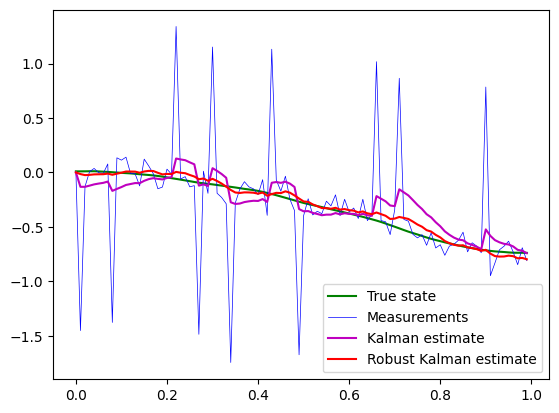

In [ ]:
print (f'KF dragged by outliers.\nRobust KF is more stable and smoother the prediction.\n')
plt.plot(t_axis, [xi[0,0] for xi in history['x']], 'g', label='True state')
plt.plot(t_axis, [zi[0,0] for zi in history['z']], 'b', linewidth=0.5, label='Measurements')
plt.plot(t_axis, [k[0,0] for k in history['x_kalman']], 'm', label='Kalman estimate')
plt.plot(t_axis, [k[0,0] for k in history['x_kalman_robust']], 'r', label='Robust Kalman estimate')
plt.legend()
plt.show()

# Example 2: Heavy-tailed distribution

Comparison of the performance of KF, Robust KF, and Particle filter with Laplace noise.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Simulation parameters
n_steps = 50
A, H = 1.0, 1
Q, R = 0.1, 0.1

# True state trajectory
x_true = np.cumsum(np.random.randn(n_steps) * np.sqrt(Q))

# Measurements with Laplace (heavy-tailed) noise
z_laplace = x_true + np.random.laplace(0, 2*np.sqrt(R), n_steps)

# -----------------------------
# Standard Kalman Filter
# -----------------------------
def kalman_filter(z):
    x_est, P = 0.0, 1.0
    estimates = []
    for k in range(len(z)):
        # Prediction
        x_pred = A * x_est
        P_pred = A * P * A + Q

        # Update
        K = P_pred * H / (H * P_pred * H + R)
        x_est = x_pred + K * (z[k] - H * x_pred)
        P = (1 - K * H) * P_pred

        estimates.append(x_est)
    return np.array(estimates)

# -----------------------------
# Robust Kalman Filter (Huber)
# -----------------------------
def huber_update(residual, delta=1.0):
    if abs(residual) <= delta:
        return residual
    else:
        return delta * np.sign(residual)

def robust_kf(z):
    x_est, P = 0.0, 1.0
    estimates = []
    for k in range(len(z)):
        x_pred = A * x_est
        P_pred = A * P * A + Q

        residual = z[k] - H * x_pred
        K = P_pred * H / (H * P_pred * H + R)
        x_est = x_pred + K * huber_update(residual)
        P = (1 - K * H) * P_pred

        estimates.append(x_est)
    return np.array(estimates)

# -----------------------------
# Particle Filter (basic)
# -----------------------------
def particle_filter(z, N=100):
    particles = np.random.randn(N)  # initial particles
    weights = np.ones(N) / N
    estimates = []

    for k in range(len(z)):
        # Prediction
        particles = A * particles + np.random.randn(N) * np.sqrt(Q)

        # Update weights
        likelihood = np.exp(-0.5 * ((z[k] - H * particles)**2) / R)
        weights *= likelihood
        weights += 1e-300  # avoid zeros
        weights /= np.sum(weights)

        # Estimate
        estimates.append(np.sum(particles * weights))

        # Resample
        idx = np.random.choice(range(N), size=N, p=weights)
        particles = particles[idx]
        weights = np.ones(N) / N

    return np.array(estimates)

# -----------------------------
# Run filters
# -----------------------------
kf_laplace = kalman_filter(z_laplace)
robust_laplace = robust_kf(z_laplace)
pf_laplace = particle_filter(z_laplace)

# -----------------------------
# Quantitative comparison
# -----------------------------
def compute_metrics(estimates, x_true):
    error = estimates - x_true
    mse = np.mean(error**2)
    maxae = np.max(np.abs(error))
    return mse, maxae

metrics = {
    "KF (Laplace noise)": compute_metrics(kf_laplace, x_true),
    "Robust KF (Laplace noise)": compute_metrics(robust_laplace, x_true),
    "Particle Filter (Laplace noise)": compute_metrics(pf_laplace, x_true),
}


Quantitative comparison (MSE and Max Absolute Error):
KF (Laplace noise): MSE=0.39192, MaxAE=1.82786
Robust KF (Laplace noise): MSE=0.25600, MaxAE=1.23646
Particle Filter (Laplace noise): MSE=0.25967, MaxAE=1.43694



KF with Laplace noise → diverges or gets pulled by outliers.
Robust KF → more stable under Laplace noise, ignores big outliers.
Particle Filter → flexible, handles Laplace noise well, but noisier and computationally heavier.



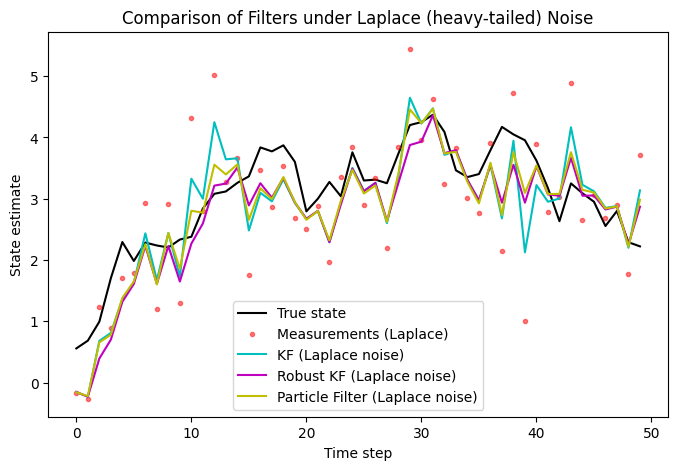

In [ ]:

print("Quantitative comparison (MSE and Max Absolute Error):")
for key, (mse, maxae) in metrics.items():
    print(f"{key}: MSE={mse:.5f}, MaxAE={maxae:.5f}")
print('\n')

print(f"\nKF with Laplace noise → diverges or gets pulled by outliers.\nRobust KF → more stable under Laplace noise, ignores big outliers.\nParticle Filter → flexible, handles Laplace noise well, but noisier and computationally heavier.\n")


plt.figure(figsize=(8,5))

plt.plot(x_true, 'k-', label="True state")
plt.plot(z_laplace, 'r.', alpha=0.5, label="Measurements (Laplace)")

plt.plot(kf_laplace, 'c-', label="KF (Laplace noise)")
plt.plot(robust_laplace, 'm-', label="Robust KF (Laplace noise)")
plt.plot(pf_laplace, 'y-', label="Particle Filter (Laplace noise)")

plt.legend()
plt.title("Comparison of Filters under Laplace (heavy-tailed) Noise")
plt.xlabel("Time step")
plt.ylabel("State estimate")
plt.show()


# Summary

* Standard KF struggles with both nonlinearity and heavy-tailed noise.
* For Laplace noise, Robust KF and Particle Filter handle outliers better.
* Particle Filter is flexible and handles both challenges but is more computationally expensive.

# References

EKF: https://www.youtube.com/watch?v=E-6paM_Iwfc

Robust Kalman Filter:
* paper:https://ieeexplore.ieee.org/abstract/document/769393
* code: https://github.com/milsto/robust-kalman/tree/master

Particle Filter:
* https://www.youtube.com/watch?v=BfKEf2s7Y80
* https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb


# Not in the presentation

## Comparison different KR variant on Gaussian and Non-gaussian noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# System parameters (nonlinear)
n_steps = 50
Q = 0.01  # process noise variance
R = 0.1   # measurement noise variance

def f(x):
    return 0.5 * x + 25 * x / (1 + x**2) + 8 * np.cos(1.2)

def h(x):
    return x**2 / 20

def dh_dx(x):
    return x / 10

def huber(residual, delta=1.0):
    return residual if abs(residual) <= delta else delta*np.sign(residual)

def rmse(estimates, true):
    return np.sqrt(np.mean((np.array(estimates) - np.array(true))**2))

# Generate true state
x_true = np.zeros(n_steps)
x_true[0] = 0.1
for k in range(1, n_steps):
    x_true[k] = f(x_true[k-1]) + np.random.randn() * np.sqrt(Q)

# ----- Generate measurements -----
z_gauss = h(x_true) + np.random.randn(n_steps) * np.sqrt(R)
z_laplace = h(x_true) + np.random.laplace(0, 2*np.sqrt(R), n_steps)

# Function to run all filters
def run_filters(z):
    # KF
    x_kf, P_kf = 0.0, 1.0
    kf_estimates = []
    for k in range(n_steps):
        x_pred = 0.5 * x_kf + 25 * x_kf / (1 + x_kf**2) + 8 * np.cos(1.2)
        P_pred = P_kf + Q
        H = 0.1
        K = P_pred * H / (H*P_pred*H + R)
        residual = z[k] - H * x_pred
        x_kf = x_pred + K * residual
        P_kf = (1 - K*H)*P_pred
        kf_estimates.append(x_kf)

    # EKF
    x_ekf, P_ekf = 0.0, 1.0
    ekf_estimates = []
    for k in range(n_steps):
        x_pred = f(x_ekf)
        P_pred = P_ekf + Q
        H = dh_dx(x_pred)
        K = P_pred * H / (H*P_pred*H + R)
        residual = z[k] - h(x_pred)
        x_ekf = x_pred + K * residual
        P_ekf = (1 - K*H)*P_pred
        ekf_estimates.append(x_ekf)

    # Robust KF (Huber)
    x_rkf, P_rkf = 0.0, 1.0
    rkf_estimates = []
    for k in range(n_steps):
        x_pred = f(x_rkf)
        P_pred = P_rkf + Q
        H = dh_dx(x_pred)
        K = P_pred * H / (H*P_pred*H + R)
        residual = z[k] - h(x_pred)
        x_rkf = x_pred + K * huber(residual, delta=np.sqrt(R))
        P_rkf = (1 - K*H)*P_pred
        rkf_estimates.append(x_rkf)

    # Particle Filter
    n_particles = 1000
    particles = np.random.randn(n_particles) * 0.1
    weights = np.ones(n_particles) / n_particles
    pf_estimates = []
    for k in range(n_steps):
        particles = f(particles) + np.random.randn(n_particles) * np.sqrt(Q)
        weights *= np.exp(-0.5*((z[k]-h(particles))**2)/R)
        weights += 1e-300
        weights /= np.sum(weights)
        indices = np.random.choice(n_particles, size=n_particles, p=weights)
        particles = particles[indices]
        weights = np.ones(n_particles)/n_particles
        pf_estimates.append(np.mean(particles))

    # Compute RMSE
    rmse_kf = rmse(kf_estimates, x_true)
    rmse_ekf = rmse(ekf_estimates, x_true)
    rmse_rkf = rmse(rkf_estimates, x_true)
    rmse_pf = rmse(pf_estimates, x_true)

    return kf_estimates, ekf_estimates, rkf_estimates, pf_estimates, (rmse_kf, rmse_ekf, rmse_rkf, rmse_pf)

# Run filters for Gaussian noise
kf_g, ekf_g, rkf_g, pf_g, rmse_g = run_filters(z_gauss)

# Run filters for Laplace noise
kf_l, ekf_l, rkf_l, pf_l, rmse_l = run_filters(z_laplace)



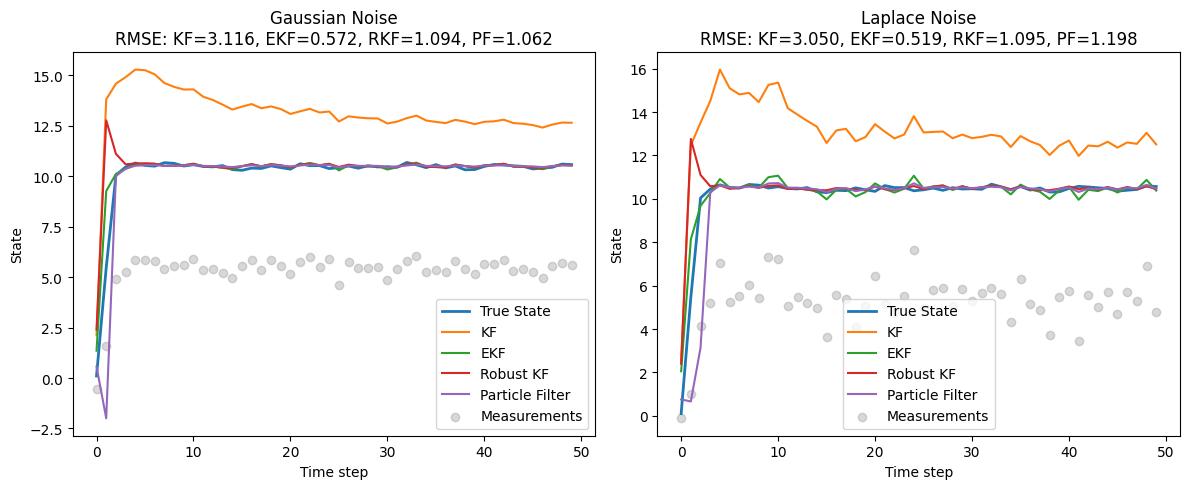

In [ ]:
# ----- Plot Gaussian noise -----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x_true, label='True State', linewidth=2)
plt.plot(kf_g, label='KF')
plt.plot(ekf_g, label='EKF')
plt.plot(rkf_g, label='Robust KF')
plt.plot(pf_g, label='Particle Filter')
plt.scatter(range(n_steps), z_gauss, color='gray', alpha=0.3, label='Measurements')
plt.title(f'Gaussian Noise\nRMSE: KF={rmse_g[0]:.3f}, EKF={rmse_g[1]:.3f}, RKF={rmse_g[2]:.3f}, PF={rmse_g[3]:.3f}')
plt.xlabel('Time step'); plt.ylabel('State'); plt.legend()

# ----- Plot Laplace noise -----
plt.subplot(1,2,2)
plt.plot(x_true, label='True State', linewidth=2)
plt.plot(kf_l, label='KF')
plt.plot(ekf_l, label='EKF')
plt.plot(rkf_l, label='Robust KF')
plt.plot(pf_l, label='Particle Filter')
plt.scatter(range(n_steps), z_laplace, color='gray', alpha=0.3, label='Measurements')
plt.title(f'Laplace Noise\nRMSE: KF={rmse_l[0]:.3f}, EKF={rmse_l[1]:.3f}, RKF={rmse_l[2]:.3f}, PF={rmse_l[3]:.3f}')
plt.xlabel('Time step'); plt.ylabel('State'); plt.legend()

plt.tight_layout()
plt.show()


## Particle filter from lecture example (git)

In [ ]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [ ]:
import numpy as np

# -------- Particle creation --------
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = np.random.uniform(hdg_range[0], hdg_range[1], size=N)
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.random.randn(N, 3) * std + mean
    return particles

# -------- PF predict step --------
def predict(particles, u, std):
    # motion = (rotation, forward-distance)
    particles[:, 2] += u[0] + np.random.randn(len(particles)) * std[0]
    particles[:, 0] += np.cos(particles[:, 2]) * (u[1] + np.random.randn(len(particles)) * std[1])
    particles[:, 1] += np.sin(particles[:, 2]) * (u[1] + np.random.randn(len(particles)) * std[1])

# -------- PF update step --------
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        dist = np.linalg.norm(particles[:, :2] - landmark, axis=1)
        weights *= scipy.stats.norm(dist, R).pdf(z[i])
    weights += 1.e-300
    weights /= np.sum(weights)

# -------- Resampling helpers --------
def neff(weights):
    return 1. / np.sum(np.square(weights))

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.uniform()) / N
    indexes = np.zeros(N, dtype=int)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = 1.0 / len(weights)

# -------- Estimate (mean and variance) --------
def estimate(particles, weights):
    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean)**2, weights=weights, axis=0)
    return mean, var


final position error, variance:
	 [-0.12266176  0.05708698] [0.00926278 0.00849005]


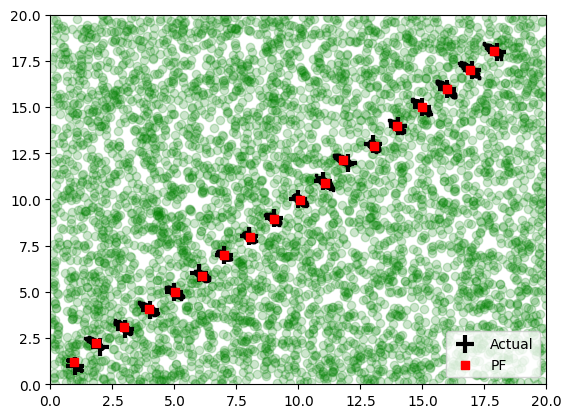

In [ ]:
#from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1,
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)

    plt.figure()

    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)
        plt.scatter(particles[:, 0], particles[:, 1],
                    alpha=alpha, color='g')

    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) +
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))

        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err,
               landmarks=landmarks)

        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')

    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print(
    'final position error, variance:\n\t',
    mu[:2] - np.array([iters, iters]),   # compare only x,y
    var[:2]                              # variance of x,y
)
    plt.show()

from numpy.random import seed
seed(2)
run_pf1(N=5000, plot_particles=True)